<a href="https://colab.research.google.com/github/NesquikPlz/Implement-Variational-Auto-encoder-for-mnist/blob/main/implement_VAE_for_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implement Variational Auto-encoder for mnist in Tensorflow
<br>
*taking lee hwalsuk's autoencoding class -> https://youtu.be/o_peo6U7IRM<br>
*this is for practicing for the purpose of full understanding<br>
*most of code comes from -> https://github.com/hwalsuklee/tensorflow-mnist-VAE


---



VAE ARCHITECTURE

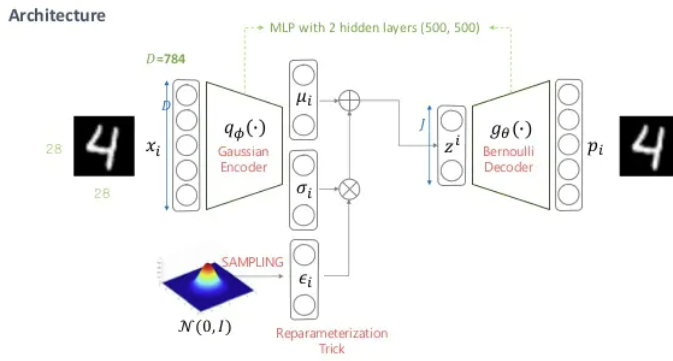

In [ ]:
import tensorflow as tf
# import numpy as np
# import os
# import vae
# import plot_utils
# import glob

# import argparse

##1. Prepare mnist data

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gzip
import os

import numpy
from scipy import ndimage

from six.moves import urllib

In [ ]:
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'
DATA_DIRECTORY = "data"

In [ ]:
# Params for MNIST
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 5000  # Size of the validation set.

In [ ]:
# Download mnist data
def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not tf.gfile.Exists(DATA_DIRECTORY):
        tf.gfile.MakeDirs(DATA_DIRECTORY)
    filepath = os.path.join(DATA_DIRECTORY, filename)
    if not tf.gfile.Exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        with tf.gfile.GFile(filepath) as f:
            size = f.size()
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath

In [ ]:
# Extract images
def extract_data(filename, num_images, norm_shift=False, norm_scale=True):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
        if norm_shift:
            data = data - (PIXEL_DEPTH / 2.0)
        if norm_scale:
            data = data / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
        data = numpy.reshape(data, [num_images, -1])
    return data


In [ ]:
# we first implement the encoder
# 2 FC hiden layers with 500 neurons
# assume that q(*) is gaussian distribution

def gaussian_MLP_encoder(x, n_hidden, n_output, keep_prob):
    with tf.variable_scope("gaussian_MLP_encoder"):
        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        w0 = tf.get_variable('w0', [x.get_shape()[1], n_hidden], initializer=w_init)
        b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        h0 = tf.matmul(x, w0) + b0  #cuz it is FC layer
        h0 = tf.nn.elu(h0)          #nonlinear activation function
        h0 = tf.nn.dropout(h0, keep_prob)#nonlinear activation function

        # 2nd hidden layer
        w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        h1 = tf.matmul(h0, w1) + b1
        h1 = tf.nn.tanh(h1)
        h1 = tf.nn.dropout(h1, keep_prob)

        # output layer
        # core part for estimate mu and sigma
        # borrowed from https: // github.com / altosaar / vae / blob / master / vae.py
        # final output is n_output*2 dimension. one for mu, and one for sigma
        wo = tf.get_variable('wo', [h1.get_shape()[1], n_output * 2], initializer=w_init)
        bo = tf.get_variable('bo', [n_output * 2], initializer=b_init)
        gaussian_params = tf.matmul(h1, wo) + bo

        # The mean parameter is unconstrained
        mean = gaussian_params[:, :n_output]  # z vector is n_output dimension
        # The standard deviation must be positive. Parametrize with a softplus and
        # add a small epsilon for numerical stability
        stddev = 1e-6 + tf.nn.softplus(gaussian_params[:, n_output:])

    return mean, stddev   # this is mu and sigma, both are n_output dimension

In [ ]:
# This is decoder part
# same structure with encoder
# Bernoulli MLP as decoder

def bernoulli_MLP_decoder(z, n_hidden, n_output, keep_prob, reuse=False):

    with tf.variable_scope("bernoulli_MLP_decoder", reuse=reuse):
        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        w0 = tf.get_variable('w0', [z.get_shape()[1], n_hidden], initializer=w_init)
        b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        h0 = tf.matmul(z, w0) + b0
        h0 = tf.nn.tanh(h0)
        h0 = tf.nn.dropout(h0, keep_prob)

        # 2nd hidden layer
        w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        h1 = tf.matmul(h0, w1) + b1
        h1 = tf.nn.elu(h1)
        h1 = tf.nn.dropout(h1, keep_prob)

        # output layer-mean
        wo = tf.get_variable('wo', [h1.get_shape()[1], n_output], initializer=w_init)
        bo = tf.get_variable('bo', [n_output], initializer=b_init)
        y = tf.sigmoid(tf.matmul(h1, wo) + bo) #output is image, so we use sigmoid as activation functino

    return y


In [ ]:
# Gateway
def autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob):

    # encoding
    mu, sigma = gaussian_MLP_encoder(x_hat, n_hidden, dim_z, keep_prob)

    # sampling by re-parameterization technique
    # use re-parameterization trick so we can backpropagate
    z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)

    # decoding
    y = bernoulli_MLP_decoder(z, n_hidden, dim_img, keep_prob)
    y = tf.clip_by_value(y, 1e-8, 1 - 1e-8) # make sure that y is in 0~1

    # loss
    marginal_likelihood = tf.reduce_sum(x * tf.log(y) + (1 - x) * tf.log(1 - y), 1) # this is reconstruction error : cross entropy 
    KL_divergence = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1, 1) # this is regulariation

    marginal_likelihood = tf.reduce_mean(marginal_likelihood)
    KL_divergence = tf.reduce_mean(KL_divergence)

    ELBO = marginal_likelihood - KL_divergence

    loss = -ELBO

    return y, z, loss, -marginal_likelihood, KL_divergence

def decoder(z, dim_img, n_hidden):

    y = bernoulli_MLP_decoder(z, n_hidden, dim_img, 1.0, reuse=True)

    return y